In [1]:
from data_loader import FootballDataLoader
from data_visualizer import Visualizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
# === Setup paths ===
data_dir = "/Users/denizadiguzel/FootballData_FromMathias_May2025/RestructuredData_2425"
team = "FCK"
save_dir = "/Users/denizadiguzel/"  # Optional, used if save=True

# === Initialize loader ===
loader = FootballDataLoader(data_dir, team)

# === Load multiple games ===
datasets = loader.load_all_games(
    n_games= 1,                     # Or use "all" to load everything
    in_play_only=True,            # Only use frames when game is in play
    speed=False,                  # Skip speed column
    z=False,                      # Skip z-coordinate
    use_artificial_players=True,  # Use fixed player slots (0–10)
    every_n=2,                    # Downsample: keep every 5th frame
    save=False,                   # Don’t save to disk
    verbose=(False, False)        # Don’t print shapes or show plots
)

# === Inspect shape of each game ===
for i, df in enumerate(datasets):
    print(f"Game {i}: shape = {df.shape}")

Reading game 1: Game_LYN_FCK_Score_0_2_Day_2024-07-22Z.pkl
Loading Game_LYN_FCK_Score_0_2_Day_2024-07-22Z.pkl
Data read.
Game 0: shape = (48274, 72)


In [ ]:
from collections import Counter

def extract_features_and_labels(datasets, user_team="FCK"):
    X, y = [], []
    all_prefixes = set()

    for df in datasets:
        # Auto-detect team and opponent from column prefixes
        prefixes = set(col.split("player_")[0] for col in df.columns if "player_0_x" in col)
        all_prefixes.update(prefixes)

        if not any(user_team in p for p in prefixes):
            raise ValueError(f"Your team '{user_team}' not found in dataset column prefixes: {prefixes}")

        team_prefix = [p for p in prefixes if user_team in p][0]
        opp_prefix = [p for p in prefixes if p != team_prefix][0]

        for _, row in df.iterrows():
            features = []

            for i in range(11):
                features += [row.get(f"{team_prefix}player_{i}_x", np.nan),
                             row.get(f"{team_prefix}player_{i}_y", np.nan)]
            for i in range(11):
                features += [row.get(f"{opp_prefix}player_{i}_x", np.nan),
                             row.get(f"{opp_prefix}player_{i}_y", np.nan)]

            if any(pd.isna(features)) or pd.isna(row["Ball_x"]) or pd.isna(row["Ball_y"]):
                continue

            X.append(features)
            y.append([row["Ball_x"], row["Ball_y"]])

    return np.array(X), np.array(y), team_prefix, opp_prefix


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def train_lightgbm_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_x = LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
    model_y = LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)

    model_x.fit(X_train, y_train[:, 0])
    model_y.fit(X_train, y_train[:, 1])

    y_pred_x = model_x.predict(X_test)
    y_pred_y = model_y.predict(X_test)
    y_pred = np.stack((y_pred_x, y_pred_y), axis=1)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\n✅ LightGBM RMSE: {rmse:.3f}")

    return model_x, model_y, X_test, y_test, y_pred


In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test[:, 0], y_test[:, 1], c='blue', alpha=0.4, label='True')
    plt.scatter(y_pred[:, 0], y_pred[:, 1], c='red', alpha=0.4, label='Predicted')
    plt.legend()
    plt.title("Predicted vs. True Ball Position")
    plt.xlabel("Ball X")
    plt.ylabel("Ball Y")
    plt.gca().set_aspect("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
from collections import Counter

def report_top_features(model, feature_names, df_all, prefix_label, user_team):
    gains = model.booster_.feature_importance(importance_type="gain")
    top_indices = np.argsort(gains)[::-1][:3]

    # Attempt to read the opponent name from DataFrame attributes
    opponent_name = df_all.attrs.get("opponent_name", "OPP")

    print(f"\n🔹 Top 2 features for predicting {prefix_label}:")
    for idx in top_indices:
        feature = feature_names[idx]
        slot = int(feature.split("player_")[1].split("_")[0])
        prefix = feature.split("player_")[0]

        print(f"  {feature} (gain = {gains[idx]:.2f})")

        # Fix label
        readable_prefix = user_team if prefix == user_team else opponent_name
        colname = f"{prefix}player_{slot}_number"

        if colname in df_all.columns:
            jerseys = df_all[colname].dropna().astype(int)
            if len(jerseys) > 0:
                most_common = Counter(jerseys).most_common(1)[0][0]
                print(f"     ↳ Most common jersey in slot {slot} ({readable_prefix}): #{most_common}")
            else:
                print(f"     ↳ No data for slot {slot}")
        else:
            print(f"     ↳ Column {colname} not found")


In [ ]:
# 1. Extract data
X, y, team_prefix, opp_prefix = extract_features_and_labels(datasets, user_team="FCK")


In [ ]:

# 2. Feature names
feature_names = [f"{team_prefix}player_{i}_{c}" for i in range(11) for c in ["x", "y"]] + \
                [f"{opp_prefix}player_{i}_{c}" for i in range(11) for c in ["x", "y"]]


In [ ]:

# 3. Train
model_x, model_y, X_test, y_test, y_pred = train_lightgbm_models(X, y)


In [ ]:

# 4. Plot
plot_predictions(y_test, y_pred)


In [ ]:

# 5. Top feature interpretation
df_all = pd.concat(datasets, ignore_index=True)
report_top_features(model_x, feature_names, df_all, prefix_label="Ball_x", user_team="FCK")
report_top_features(model_y, feature_names, df_all, prefix_label="Ball_y", user_team="FCK")

# ----------- LETS START TRAINING -----------

In [3]:
def extract_features_with_bally(datasets, team_prefix="FCK"):
    X, y = [], []

    for df in datasets:
        # Auto-detect opponent prefix
        prefixes = set(col.split("player_")[0] for col in df.columns if "_x" in col and "player_" in col)
        prefixes.discard(team_prefix)
        if not prefixes:
            continue
        opponent_prefix = list(prefixes)[0]

        for _, row in df.iterrows():
            features = []

            # Team players
            for i in range(11):
                features.append(row.get(f"{team_prefix}player_{i}_x", np.nan))
                features.append(row.get(f"{team_prefix}player_{i}_y", np.nan))

            # Opponent players
            for i in range(11):
                features.append(row.get(f"{opponent_prefix}player_{i}_x", np.nan))
                features.append(row.get(f"{opponent_prefix}player_{i}_y", np.nan))

            # Add Ball_y as input
            ball_y = row.get("Ball_y", np.nan)

            if any(pd.isna(features)) or pd.isna(row["Ball_x"]) or pd.isna(ball_y):
                continue

            features.append(ball_y)  # <-- appended here
            X.append(features)
            y.append(row["Ball_x"])

    return np.array(X), np.array(y)


In [8]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Extract new features
X_ballx, y_ballx = extract_features_with_bally(datasets, team_prefix="FCK")

# Split
X_train, X_test, y_train, y_test = train_test_split(X_ballx, y_ballx, test_size=0.2, random_state=42)

# Train model
model_ballx_cond = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=64,
    max_depth=10,
    min_data_in_leaf=20,
    random_state=42
)

model_ballx_cond.fit(X_train, y_train)

# Evaluate
y_pred = model_ballx_cond.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Conditional Ball_x RMSE (with Ball_y as input): {rmse:.3f}")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11475
[LightGBM] [Info] Number of data points in the train set: 38619, number of used features: 45
[LightGBM] [Info] Start training from score -1.856800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_i

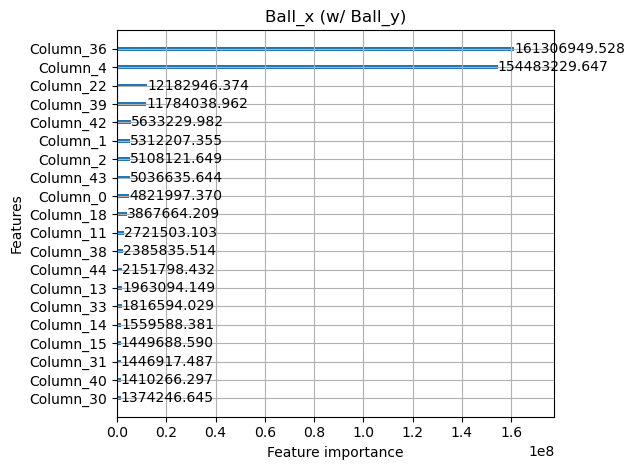

In [9]:
import matplotlib.pyplot as plt
import lightgbm as lgb

feature_names_cond = [f"FCKplayer_{i}_{a}" for i in range(11) for a in ("x", "y")] + \
                     [f"OPPplayer_{i}_{a}" for i in range(11) for a in ("x", "y")] + \
                     ["Ball_y"]

lgb.plot_importance(model_ballx_cond, max_num_features=20, importance_type="gain", title="Ball_x (w/ Ball_y)")
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_custom_importance(model, feature_names, top_n=20, title="Feature Importance"):
    # Get importance
    importances = model.booster_.feature_importance(importance_type="gain")
    features_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })

    # Sort and select top
    features_df = features_df.sort_values("importance", ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(features_df["feature"][::-1], features_df["importance"][::-1], color="skyblue")
    plt.xlabel("Gain")
    plt.title(title)
    plt.grid(axis='x', linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


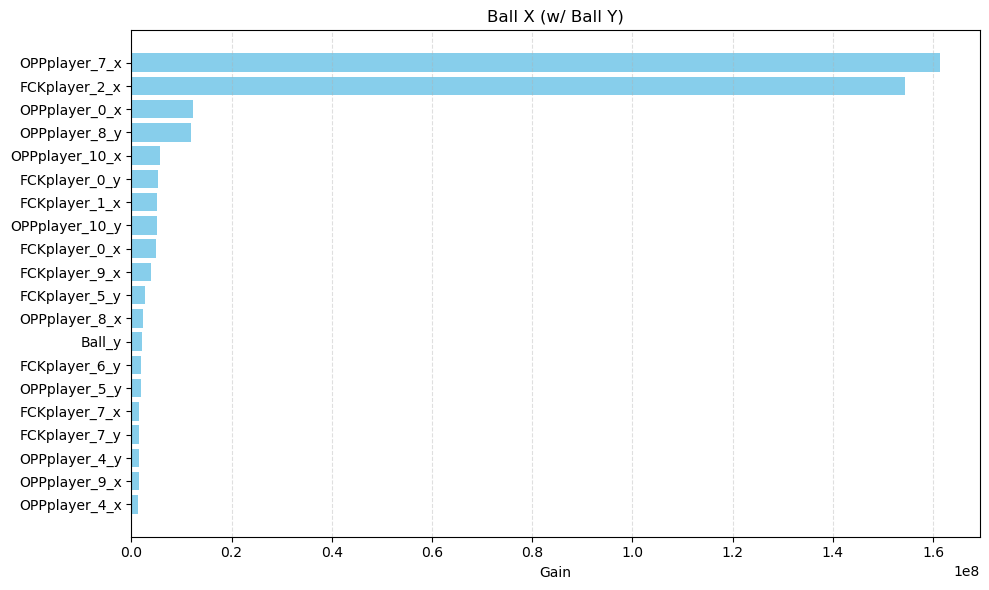

In [11]:
plot_custom_importance(model_ballx_cond, feature_names_cond, title="Ball X (w/ Ball Y)")


In [15]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def get_most_common_jersey(df, prefix, slot):
    col = f"{prefix}player_{slot}_number"
    if col not in df.columns:
        return None
    jerseys = df[col].dropna().astype(int)
    if len(jerseys) == 0:
        return None
    return Counter(jerseys).most_common(1)[0][0]

def plot_feature_importance_with_jerseys(model, feature_names, df_all, top_n=20, title="Feature Importance"):
    importances = model.booster_.feature_importance(importance_type="gain")
    df_imp = pd.DataFrame({"feature": feature_names, "gain": importances})
    df_imp = df_imp.sort_values("gain", ascending=False).head(top_n)

    readable_labels = []
    for feat in df_imp["feature"]:
        try:
            prefix = feat.split("player_")[0]
            slot = int(feat.split("player_")[1].split("_")[0])
            base = feat.split("_")[-1]  # 'x' or 'y'

            jersey = get_most_common_jersey(df_all, prefix, slot)
            if jersey is not None:
                label = f"{prefix}_#{jersey}_{base}"
            else:
                label = feat
        except:
            label = feat
        readable_labels.append(label)

    df_imp["label"] = readable_labels

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(df_imp["label"][::-1], df_imp["gain"][::-1], color="skyblue")
    plt.xlabel("Gain")
    plt.title(title)
    plt.grid(axis='x', linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()


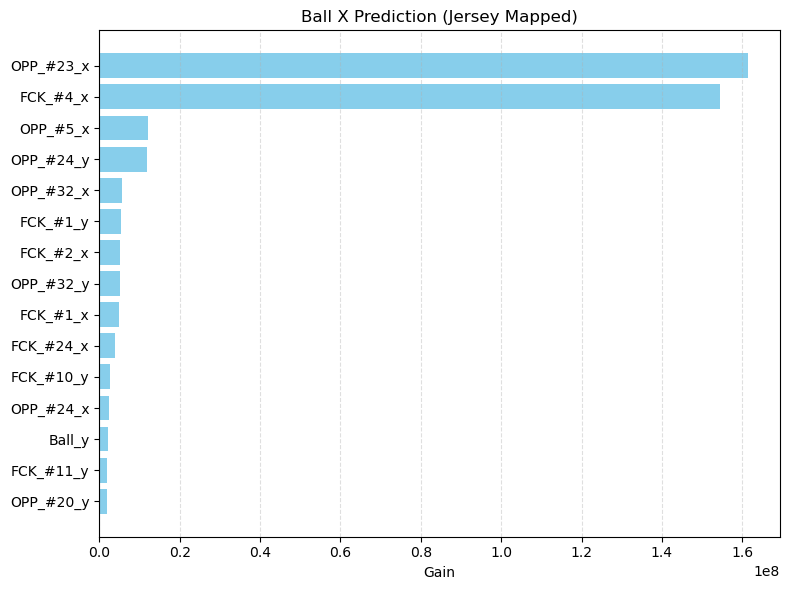

In [16]:
df_all = pd.concat(datasets, ignore_index=True)

plot_feature_importance_with_jerseys(
    model_ballx_cond,
    feature_names_cond,
    df_all,
    top_n=15,
    title="Ball X Prediction (Jersey Mapped)"
)
